# Comparing Pangenome pipeline predictions - Shaw2021 - 50 e. coli genomes

### Import Statements

In [1]:
import numpy as np
import pandas as pd
import vcf
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import scipy.stats

%matplotlib inline

#### Pandas Viewing Settings

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:

def read_PanarooSummaryStats(input_Panaroo_SummaryStats_TXT):
    
    i_Panaroo_Stats_DF = pd.read_csv(input_Panaroo_SummaryStats_TXT, sep = "\t", header=None)
    i_Panaroo_Stats_DF.columns = ["Category", "Range", "GeneCount"]

    Acc_GenesCount = i_Panaroo_Stats_DF["GeneCount"].values[-1] - i_Panaroo_Stats_DF["GeneCount"].values[0]

    i_Panaroo_AccGenesRow = ["Accessory genes","(0% <= strains < 99%)", Acc_GenesCount]

    i_Panaroo_Stats_DF.loc[len(i_Panaroo_Stats_DF.index)] = i_Panaroo_AccGenesRow

    #listOfCat_ToKeep = ["Core genes", "Accessory Genes", "Total genes"]

    i_Panaroo_Stats_DF = i_Panaroo_Stats_DF[ i_Panaroo_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

    # https://www.statology.org/pandas-add-row-to-dataframe/#:~:text=You%20can%20use%20the%20df,loc%5Blen(df. 

    return i_Panaroo_Stats_DF

In [4]:
def read_Ppanggolin_ContextStats(i_Ppanggolin_Default_Content_TXT):
    with open(i_Ppanggolin_Default_Content_TXT, "r") as f:

        #NumCoreGenes = -1
        #NumShellGenes = -1
        #NumCloudGenes = -1
        for line in f:
            line_split = line.split(": ")

            Key = line_split[0].split(" (")[0]
            Value = line_split[-1].strip()

            if Key == "Persistent": NumCoreGenes = int(Value)
            elif Key == "Shell": NumShellGenes = int(Value)
            elif Key == "Cloud": NumCloudGenes = int(Value)

        NumAccessoryGenes = NumShellGenes + NumCloudGenes
        NumTotalGenes = NumCoreGenes + NumAccessoryGenes

    listOf_PG_Rows = []
    listOf_PG_Rows.append( ("Total genes", "(0% <= strains <= 100%)", NumTotalGenes) )
    listOf_PG_Rows.append( ("Accessory genes", "(0% <= strains < 99%)", NumAccessoryGenes) )
    listOf_PG_Rows.append( ("Core genes", "(99% <= strains <= 100%)", NumCoreGenes) )

    PPanggolin_Summary_DF = pd.DataFrame(listOf_PG_Rows)
    PPanggolin_Summary_DF.columns = ["Category", "Range", "GeneCount"]
    
    return PPanggolin_Summary_DF

## Define paths to sample metadata files & key directories

In [5]:

Proj_MainDir = "/n/data1/hms/dbmi/farhat/mm774/Projects"

Ecoli_PG_MainDir = f"{Proj_MainDir}/230905_Ecoli_PG_Analysis"  

Data_MainDir = f"{Ecoli_PG_MainDir}/Data"  

#RefSeq_20Asm_Dir = f"{Data_MainDir}/NCBI.RefSeq.20.EcoliGenomes.dataset/data"

Shaw2021_50Asm_Dir = f"{Data_MainDir}/Shaw2021.50Genomes.Data/data"

Shaw2021_Meta_TSV = f"{Data_MainDir}/Shaw2021.SelectedIsolates.50I.tsv"  

input_FA_PATH_TSVs_Dir = f"{Ecoli_PG_MainDir}/input_PATH_SMK_TSVs"

Shaw2021_Ecoli_50Asm_Meta_TSV = f"{input_FA_PATH_TSVs_Dir}/231011.Shaw2021.Ecoli.50I.MetaData.tsv"


## Parse in metadata DFs

In [6]:
Shaw_50A_Info_DF = pd.read_csv(Shaw2021_Ecoli_50Asm_Meta_TSV, sep = "\t")
Shaw_50A_Info_DF.shape

(50, 24)

### Define list of SampleIDs

In [7]:
Shaw_50A_Info_DF.head(1)  

,Isolate,Biosample Accession,Short Reads Accession,Long Reads Accession,Assembly Accession,Animal or WwTW,Isolate source information,Timepoint,Niche,Niche.2,Location,Genus,Species,ST assignment,Circularised plasmids,Number of contigs,Circularised chromosome (1=yes),Total genome size (bp),Chromosome GC (if known),Phylogroup (E. coli only),Alternative isolate name,Long read sequencing method,SampleID,Genome_ASM_PATH
0,RH02|T1-C02,SAMN15147960,SRR11948863,SRR12299015,GCA_014109125.1,Animal,Pooled pig faecal samples collected from floor...,1,Pig,Faeces,RH02,Escherichia,Escherichia coli,10.0,1,2,1,4953790,50.7,A,RHB02-C02,PacBio,GCA_014109125,/n/data1/hms/dbmi/farhat/mm774/Projects/230905...


In [8]:
E50I_SampleIDs = Shaw_50A_Info_DF["SampleID"].values   
len(E50I_SampleIDs)

50

# Define output dir of the Mtb-WGA-SMK processing pipeline

In [9]:
# Define varaint calling pipeline output directories

WGA_SMK_Outputs_Dir = f"{Ecoli_PG_MainDir}/SMK_OutDirs"

#PG_Ecoli_20I_OutDir = WGA_SMK_Outputs_Dir + "/230905_Ecoli_2OI_V1"
PG_Ecoli_50I_OutDir = WGA_SMK_Outputs_Dir + "/231011_Ecoli_Shaw2021_5OI_V1"


In [10]:
!ls -alh $PG_Ecoli_50I_OutDir

total 1.9M
drwxrwsr-x 59 mm774 farhat 1.8K Jan  1 18:03 .
drwxrwsr-x  4 mm774 farhat   83 Oct 11 23:17 ..
drwxrwsr-x 53 mm774 farhat 1.6K Oct 12 01:52 AsmAnalysis
drwxrwsr-x  4 mm774 farhat   63 Oct 12 02:14 FastANI
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013602835
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013712565
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013713325
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013728735
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013732895
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:09 GCA_013745515
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013746655
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013750375
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:09 GCA_013752075
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013752295
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:09 GCA_013782445
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:13 GCA_013783465
drwxrwsr-x  3 mm774 farhat   29 Nov 16 00:11 GCA_013786125
drwxrwsr-x  3 mm7

In [11]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', #'Panaroo_Strict','Panaroo_Moderate', 'Panaroo_Sensitive',
                         'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',] #'Ppanggolin_Default',]


target_OutputDir = PG_Ecoli_50I_OutDir

i_Pangenome_Dir = f"{target_OutputDir}/PanGenome_Analysis"

listOfCat_ToKeep = ["Core genes", "Accessory genes", "Total genes"]


dictOf_PG_OutInfo = {}
dictOf_PG_PresAbs_DF = {}
dictOf_PG_OutDir_PATHs = {}

for i_SampleSet in ["All"]:
    
    dictOf_PG_OutInfo[i_SampleSet] = {}
    dictOf_PG_OutDir_PATHs[i_SampleSet] = {}
    dictOf_PG_PresAbs_DF[i_SampleSet] = {}
    
    for AnnoPipeline in ["Bakta"]:
        
        dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline] = {}
        dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline] = {}
        
        for AsmTech in ["LongRead", "ShortRead"]:       
            
            dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech] = {}
            dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech] = {}
            
            
            for i_PipeNameWiParam in tqdm(PipeName_WiParam_List):
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = {}
                
                if (AsmTech == "ShortRead") & (AnnoPipeline == "PGAP"): continue 
                if (i_SampleSet == "HighBUSCOIsolates") & (AnnoPipeline == "PGAP"): continue 
                
                if i_SampleSet == "All": DataSetSuffix = "_AllIsolates"  
                elif i_SampleSet == "HighBUSCOIsolates": DataSetSuffix = "_HighBUSCOIsolates"

                if AsmTech == "LongRead": SeqTechPrefix = ""
                elif AsmTech == "ShortRead": SeqTechPrefix = "SR_"

                if AnnoPipeline == "Bakta": AnnoSuffix = ""
                elif AnnoPipeline == "PGAP": AnnoSuffix = "_WiPGAPAnno_V1"


                i_Pipeline_OutDir = f"{i_Pangenome_Dir}/"+SeqTechPrefix+i_PipeNameWiParam+DataSetSuffix+AnnoSuffix

                if "Panaroo" in i_PipeNameWiParam:
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   
                    
                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    
                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"
                    
                    #i_Gene_PresAbs_DF = parse_Panaroo_GenePresAbs_CSV(i_Gene_PresAbs_CSV_PATH)  

                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH


                elif "Roary" in i_PipeNameWiParam:
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/summary_statistics.txt"

                    i_PG_Stats_DF = read_PanarooSummaryStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

                    i_Gene_PresAbs_CSV_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.csv"    

                    i_Pangenome_Ref_FA_PATH = f"{i_Pipeline_OutDir}/pan_genome_reference.fa"

                    
                    #i_Gene_PresAbs_DF = parse_Panaroo_GenePresAbs_CSV(i_Gene_PresAbs_CSV_PATH)  
                    
                    
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_CSV"] = i_Gene_PresAbs_CSV_PATH
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Pangenome_Ref_FA"] = i_Pangenome_Ref_FA_PATH

                    
                elif "Ppanggolin" in i_PipeNameWiParam:
                    i_PG_Summary_Txt = f"{i_Pipeline_OutDir}/pangenome.ContentSummary.txt"

                    i_PG_Stats_DF = read_Ppanggolin_ContextStats(i_PG_Summary_Txt)
                    i_PG_Stats_DF["Annotation"] = AnnoPipeline
                    i_PG_Stats_DF["Method"] = i_PipeNameWiParam
                    i_PG_Stats_DF["SeqType"] = AsmTech
                    i_PG_Stats_DF["DataSet"] = i_SampleSet
                    
                    i_PG_Stats_DF = i_PG_Stats_DF[ i_PG_Stats_DF["Category"].isin(listOfCat_ToKeep)]   

                    i_Gene_PresAbs_Rtab_PATH = f"{i_Pipeline_OutDir}/gene_presence_absence.Rtab"    
                    
                    #i_Gene_PresAbs_DF = parse_Panaroo_GenePresAbs_Rtab(i_Gene_PresAbs_Rtab_PATH)
                                          
                    dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["PresAbs_Rtab"] = i_Gene_PresAbs_Rtab_PATH


                dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_PG_Stats_DF
                
                #dictOf_PG_PresAbs_DF[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam] = i_Gene_PresAbs_DF
                
                dictOf_PG_OutDir_PATHs[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]["Stats_TXT"] = i_PG_Summary_Txt


100%|██████████| 7/7 [00:00<00:00, 87.82it/s]


In [12]:
dictOf_PG_OutInfo["All"]["Bakta"]["LongRead"]["Panaroo_Strict_MergeParalogs"]   

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All


In [13]:
dictOf_PG_OutInfo["All"]["Bakta"]["ShortRead"]["Panaroo_Strict_MergeParalogs"]


,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet
0,Core genes,(99% <= strains <= 100%),2834,Bakta,Panaroo_Strict_MergeParalogs,ShortRead,All
4,Total genes,(0% <= strains <= 100%),12836,Bakta,Panaroo_Strict_MergeParalogs,ShortRead,All
5,Accessory genes,(0% <= strains < 99%),10002,Bakta,Panaroo_Strict_MergeParalogs,ShortRead,All


# 1) Merge all Pan-genome counts accross all combinations evaluated

In [14]:

PipeName_WiParam_List = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                         'Panaroo_Sensitive_MergeParalogs', #'Panaroo_Strict', Panaroo_Moderate', 'Panaroo_Sensitive',
                         'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                         'Roary_NoSplitParalogs',  'Roary_Default',] # 'Ppanggolin_Default']


listOf_PG_InfoDFs = []
for i_SampleSet in ["All"]: # "HighBUSCOIsolates"
    for AnnoPipeline in ["Bakta"]:
        for AsmTech in ["LongRead", "ShortRead"]:
            for i_PipeNameWiParam in PipeName_WiParam_List:
                i_PG_Stats_DF = dictOf_PG_OutInfo[i_SampleSet][AnnoPipeline][AsmTech][i_PipeNameWiParam]
                
                listOf_PG_InfoDFs.append(i_PG_Stats_DF)


PG_Merged_Stats_LRandSR_DF = pd.concat(listOf_PG_InfoDFs)

PG_Merged_Stats_LRandSR_DF["MethodAndTech"] = PG_Merged_Stats_LRandSR_DF["Method"] + "_" +PG_Merged_Stats_LRandSR_DF["SeqType"]

PG_Merged_Stats_LRandSR_DF.shape


(42, 8)

In [15]:
PG_Merged_Stats_LRandSR_DF["Range"].value_counts()

(99% <= strains <= 100%)    14
(0% <= strains <= 100%)     14
(0% <= strains < 99%)       14
Name: Range, dtype: int64

In [16]:
PG_Merged_Stats_LRandSR_DF.shape

(42, 8)

## Divide Pan-genome summary stats by "assembly type" and "gene category"

In [17]:
PG_Merged_Stats_LRandSR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ")
PG_Merged_Stats_LRandSR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ")
PG_Merged_Stats_LRandSR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ")

In [18]:
PG_Merged_Stats_LR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'LongRead'  ")
PG_Merged_Stats_LR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'LongRead'  ")

In [19]:
PG_Merged_Stats_SR_Pangenome_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Total genes'  ").query(" SeqType == 'ShortRead'  ")
PG_Merged_Stats_SR_Core_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Core genes'  ").query(" SeqType == 'ShortRead'  ")
PG_Merged_Stats_SR_Acc_DF = PG_Merged_Stats_LRandSR_DF.query(" Category == 'Accessory genes'  ").query(" SeqType == 'ShortRead'  ")

In [20]:
# PG_Merged_Stats_LR_DF = pd.concat([Panaroo_Strict_Stats_DF,
#                                 Panaroo_Moderate_Stats_DF,
#                                 Panaroo_Sensitive_Stats_DF,
#                                 Roary_Default_Stats_DF,
#                                 Roary_NoSplit_Stats_DF,
#                                 Roary_NoSplitI90_Stats_DF,
#                                 Ppanggolin_Default_Stats_DF])

# PG_Merged_Stats_LR_DF.shape

### Explore data structure a bit

In [21]:
PG_Merged_Stats_LRandSR_DF.head(4)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead
0,Core genes,(99% <= strains <= 100%),3036,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead


In [22]:
PG_Merged_Stats_LRandSR_DF["Category"].value_counts()

Core genes         14
Total genes        14
Accessory genes    14
Name: Category, dtype: int64

# 2) Create Pan-genome summary table - Wide version 

This table will have pangenome predictions (Total, Core, and Accessory genes) across all methods + technologies.

### Pivot table to get summary per Method and Seqtype

In [23]:
PG_Merged_Stats_LRandSR_DF.head(2)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead


In [24]:
PG_WideSumm_DF = pd.pivot(PG_Merged_Stats_LRandSR_DF,
                          index = ["MethodAndTech"],
                          columns = ["Category"],
                          values = ["GeneCount"] )    

PG_WideSumm_DF.columns = PG_WideSumm_DF.columns.droplevel(0)
PG_WideSumm_DF.columns.name = None
PG_WideSumm_DF = PG_WideSumm_DF.reset_index()


PG_WideSumm_DF["SeqType"] = PG_WideSumm_DF["MethodAndTech"].str.split("_").str[-1]
PG_WideSumm_DF["Method"] = PG_WideSumm_DF["MethodAndTech"].str.replace("_LongRead", "").str.replace("_ShortRead", "")
PG_WideSumm_DF["PangenomeTool"] = PG_WideSumm_DF["MethodAndTech"].str.split("_").str[0:1].str[0]

# Do some reformatting 
NewColOrder = ['PangenomeTool', 'SeqType', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_WideSumm_DF = PG_WideSumm_DF[NewColOrder]

PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["SeqType", "PangenomeTool", "Accessory genes"]).reset_index(drop=True)

In [25]:
PG_WideSumm_DF.columns

Index(['PangenomeTool', 'SeqType', 'Method', 'Total genes', 'Core genes', 'Accessory genes'], dtype='object')

In [26]:
#PG_WideSumm_DF

In [27]:
PG_WideSumm_DF.query("SeqType == 'LongRead'")   

,PangenomeTool,SeqType,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,Panaroo_Strict_MergeParalogs,14410,3035,11375
1,Panaroo,LongRead,Panaroo_Moderate_MergeParalogs,14641,3036,11605
2,Panaroo,LongRead,Panaroo_Sensitive_MergeParalogs,15032,3036,11996
3,Roary,LongRead,Roary_NoSplitParalogs_I80,13312,3035,10277
4,Roary,LongRead,Roary_NoSplitParalogs_I90,14851,2915,11936
5,Roary,LongRead,Roary_NoSplitParalogs,17783,2484,15299
6,Roary,LongRead,Roary_Default,21400,2394,19006


In [28]:
PG_WideSumm_DF.query("SeqType == 'ShortRead'")    

,PangenomeTool,SeqType,Method,Total genes,Core genes,Accessory genes
7,Panaroo,ShortRead,Panaroo_Strict_MergeParalogs,12836,2834,10002
8,Panaroo,ShortRead,Panaroo_Moderate_MergeParalogs,13462,2834,10628
9,Panaroo,ShortRead,Panaroo_Sensitive_MergeParalogs,15524,2834,12690
10,Roary,ShortRead,Roary_NoSplitParalogs_I80,13420,2825,10595
11,Roary,ShortRead,Roary_NoSplitParalogs_I90,14933,2711,12222
12,Roary,ShortRead,Roary_NoSplitParalogs,17825,2314,15511
13,Roary,ShortRead,Roary_Default,19721,2234,17487


In [29]:
PG_WideSumm_DF

,PangenomeTool,SeqType,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,Panaroo_Strict_MergeParalogs,14410,3035,11375
1,Panaroo,LongRead,Panaroo_Moderate_MergeParalogs,14641,3036,11605
2,Panaroo,LongRead,Panaroo_Sensitive_MergeParalogs,15032,3036,11996
3,Roary,LongRead,Roary_NoSplitParalogs_I80,13312,3035,10277
4,Roary,LongRead,Roary_NoSplitParalogs_I90,14851,2915,11936
5,Roary,LongRead,Roary_NoSplitParalogs,17783,2484,15299
6,Roary,LongRead,Roary_Default,21400,2394,19006
7,Panaroo,ShortRead,Panaroo_Strict_MergeParalogs,12836,2834,10002
8,Panaroo,ShortRead,Panaroo_Moderate_MergeParalogs,13462,2834,10628
9,Panaroo,ShortRead,Panaroo_Sensitive_MergeParalogs,15524,2834,12690


# Plotting key figures (For SR vs LR - Bakta + 3 pipelines)

# Table 1) Pan-genome predictions - LR vs SR - 3 pipelines

In [30]:
PG_WideSumm_DF.head(1)

,PangenomeTool,SeqType,Method,Total genes,Core genes,Accessory genes
0,Panaroo,LongRead,Panaroo_Strict_MergeParalogs,14410,3035,11375


In [31]:
#print(PG_WideSumm_DF.to_latex())

In [32]:
PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["Method", "SeqType"])

In [33]:
PG_WideSumm_DF

,PangenomeTool,SeqType,Method,Total genes,Core genes,Accessory genes
1,Panaroo,LongRead,Panaroo_Moderate_MergeParalogs,14641,3036,11605
8,Panaroo,ShortRead,Panaroo_Moderate_MergeParalogs,13462,2834,10628
2,Panaroo,LongRead,Panaroo_Sensitive_MergeParalogs,15032,3036,11996
9,Panaroo,ShortRead,Panaroo_Sensitive_MergeParalogs,15524,2834,12690
0,Panaroo,LongRead,Panaroo_Strict_MergeParalogs,14410,3035,11375
7,Panaroo,ShortRead,Panaroo_Strict_MergeParalogs,12836,2834,10002
6,Roary,LongRead,Roary_Default,21400,2394,19006
13,Roary,ShortRead,Roary_Default,19721,2234,17487
5,Roary,LongRead,Roary_NoSplitParalogs,17783,2484,15299
12,Roary,ShortRead,Roary_NoSplitParalogs,17825,2314,15511


In [34]:
PG_WideSumm_DF["Weight"] = PG_WideSumm_DF.groupby("Method")["Accessory genes"].transform('sum') / 2

In [35]:
#PG_WideSumm_DF

In [36]:
orderToPlot_X = ['Panaroo_Strict_MergeParalogs',
                 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs', 
                 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default', ]

dictOfValues_To_Label = {'Panaroo_Strict_MergeParalogs': 'Panaroo (Strict & MergeParalogs)',
                         'Panaroo_Moderate_MergeParalogs': 'Panaroo (Moderate & MergeParalogs)',
                         'Panaroo_Sensitive_MergeParalogs': 'Panaroo (Sensitive & MergeParalogs)',
                         'Roary_NoSplitParalogs_I90': 'Roary (MergeParalogs & I90)',
                         'Roary_NoSplitParalogs': 'Roary (MergeParalogs)',
                         'Roary_Default': 'Roary (Default)' }



PG_WideSumm_DF = PG_WideSumm_DF.sort_values("Method", key=lambda x: pd.Categorical(x, categories=orderToPlot_X, ordered=True))
#PG_WideSumm_DF = PG_WideSumm_DF.sort_values(["Method", "SeqType"], key=lambda x: pd.Categorical(x, categories=orderToPlot_X, ordered=True))

PG_WideSumm_V2_DF = PG_WideSumm_DF.copy()

PG_WideSumm_V2_DF["Method"] = PG_WideSumm_V2_DF["Method"].replace(dictOfValues_To_Label)


PG_WideSumm_V2_DF_Trim = PG_WideSumm_V2_DF[['PangenomeTool', 'Method', 'SeqType', 'Total genes', 'Core genes', 'Accessory genes']].reset_index(drop=True)

PG_WideSumm_V2_DF_Trim

,PangenomeTool,Method,SeqType,Total genes,Core genes,Accessory genes
0,Panaroo,Panaroo (Strict & MergeParalogs),LongRead,14410,3035,11375
1,Panaroo,Panaroo (Strict & MergeParalogs),ShortRead,12836,2834,10002
2,Panaroo,Panaroo (Moderate & MergeParalogs),LongRead,14641,3036,11605
3,Panaroo,Panaroo (Moderate & MergeParalogs),ShortRead,13462,2834,10628
4,Panaroo,Panaroo (Sensitive & MergeParalogs),LongRead,15032,3036,11996
5,Panaroo,Panaroo (Sensitive & MergeParalogs),ShortRead,15524,2834,12690
6,Roary,Roary_NoSplitParalogs_I80,LongRead,13312,3035,10277
7,Roary,Roary_NoSplitParalogs_I80,ShortRead,13420,2825,10595
8,Roary,Roary (MergeParalogs & I90),LongRead,14851,2915,11936
9,Roary,Roary (MergeParalogs & I90),ShortRead,14933,2711,12222


In [37]:
# https://stackoverflow.com/questions/35634238/how-to-save-a-pandas-dataframe-table-as-a-png   

In [38]:
#from pandas.table.plotting import table # EDIT: see deprecation warnings below
#from pandas.plotting import table 
#ax = plt.subplot(111, frame_on=False) # no visible frame
#ax.xaxis.set_visible(False)  # hide the x axis
#ax.yaxis.set_visible(False)  # hide the y axis

#table(ax, PG_WideSumm_V2_DF_Trim)  # where df is your data frame


In [39]:
PG_WideSumm_V2_DF.columns

Index(['PangenomeTool', 'SeqType', 'Method', 'Total genes', 'Core genes', 'Accessory genes', 'Weight'], dtype='object')

In [40]:
orderToPlot_X = ['Panaroo_Strict_MergeParalogs',
                 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs', 
                 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default', ]

dictOfValues_To_Label = {'Panaroo_Strict_MergeParalogs': 'Panaroo (Strict & MergeParalogs)',
                         'Panaroo_Moderate_MergeParalogs': 'Panaroo (Moderate & MergeParalogs)',
                         'Panaroo_Sensitive_MergeParalogs': 'Panaroo (Sensitive & MergeParalogs)',
                         'Roary_NoSplitParalogs_I90': 'Roary (MergeParalogs & I90)',
                         'Roary_NoSplitParalogs': 'Roary (MergeParalogs)',
                         'Roary_Default': 'Roary (Default)' }


# dictOfValues_To_Label = {}  

# for i in range(len(orderToPlot_X)):
        
#     dictOfValues_To_Label[MethodValues_X[i]]   =   dictOfValues_To_Label[ orderToPlot_X[i] ]
    

In [41]:
dictOfValues_To_Label.keys()
#['Panaroo_Strict_MergeParalogs'] 

dict_keys(['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs', 'Panaroo_Sensitive_MergeParalogs', 'Roary_NoSplitParalogs_I90', 'Roary_NoSplitParalogs', 'Roary_Default'])

In [42]:
orderToPlot_X[0]

'Panaroo_Strict_MergeParalogs'

In [43]:
dictOfValues_To_Label

{'Panaroo_Strict_MergeParalogs': 'Panaroo (Strict & MergeParalogs)',
 'Panaroo_Moderate_MergeParalogs': 'Panaroo (Moderate & MergeParalogs)',
 'Panaroo_Sensitive_MergeParalogs': 'Panaroo (Sensitive & MergeParalogs)',
 'Roary_NoSplitParalogs_I90': 'Roary (MergeParalogs & I90)',
 'Roary_NoSplitParalogs': 'Roary (MergeParalogs)',
 'Roary_Default': 'Roary (Default)'}

In [44]:
dictOfValues_To_Label = {'Panaroo_Strict_MergeParalogs': 'Panaroo (Strict & MergeParalogs)',
                         'Panaroo_Moderate_MergeParalogs': 'Panaroo (Moderate & MergeParalogs)',
                         'Panaroo_Sensitive_MergeParalogs': 'Panaroo (Sensitive & MergeParalogs)',
                         'Panaroo_Strict': 'Panaroo (Strict)',
                         'Panaroo_Moderate': 'Panaroo (Moderate)',
                         'Panaroo_Sensitive': 'Panaroo (Sensitive)',
                         'Roary_NoSplitParalogs_I80': 'Roary (MergeParalogs & I80)',
                         'Roary_NoSplitParalogs_I90': 'Roary (MergeParalogs & I90)',
                         'Roary_NoSplitParalogs': 'Roary (MergeParalogs)',
                         'Roary_Default': 'Roary (Default)',
                         'Ppanggolin_Default': 'Ppanggolin (Default)'}


In [45]:
PG_WideSumm_DF.groupby("SeqType")["Total genes"].describe()

,count,mean,std,min,25%,50%,75%,max
SeqType,,,,,,,,
LongRead,7.0,15918.428571,2773.387271,13312.0,14525.5,14851.0,16407.5,21400.0
ShortRead,7.0,15388.714286,2550.639770,12836.0,13441.0,14933.0,16674.5,19721.0


In [46]:
PG_WideSumm_DF.head(4)

,PangenomeTool,SeqType,Method,Total genes,Core genes,Accessory genes,Weight
0,Panaroo,LongRead,Panaroo_Strict_MergeParalogs,14410,3035,11375,10688.5
7,Panaroo,ShortRead,Panaroo_Strict_MergeParalogs,12836,2834,10002,10688.5
1,Panaroo,LongRead,Panaroo_Moderate_MergeParalogs,14641,3036,11605,11116.5
8,Panaroo,ShortRead,Panaroo_Moderate_MergeParalogs,13462,2834,10628,11116.5


In [47]:
PG_WideSumm_DF.to_csv("PG.LRvsSR.BaktaAnno.tsv", sep="\t", index= False)  

In [48]:
PG_Merged_Stats_LRandSR_DF.to_csv("PG.LRvsSR.BaktaAnno.MergedStats.tsv", sep="\t", index= False)  

In [49]:
PG_Merged_Stats_LRandSR_DF.columns   

Index(['Category', 'Range', 'GeneCount', 'Annotation', 'Method', 'SeqType', 'DataSet', 'MethodAndTech'], dtype='object')

In [50]:
PG_Merged_Stats_LRandSR_DF.head(2)  

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead


## Figure 1) Pan-genome predictions - LR vs SR - 3 pipelines - boxplot + stripplots

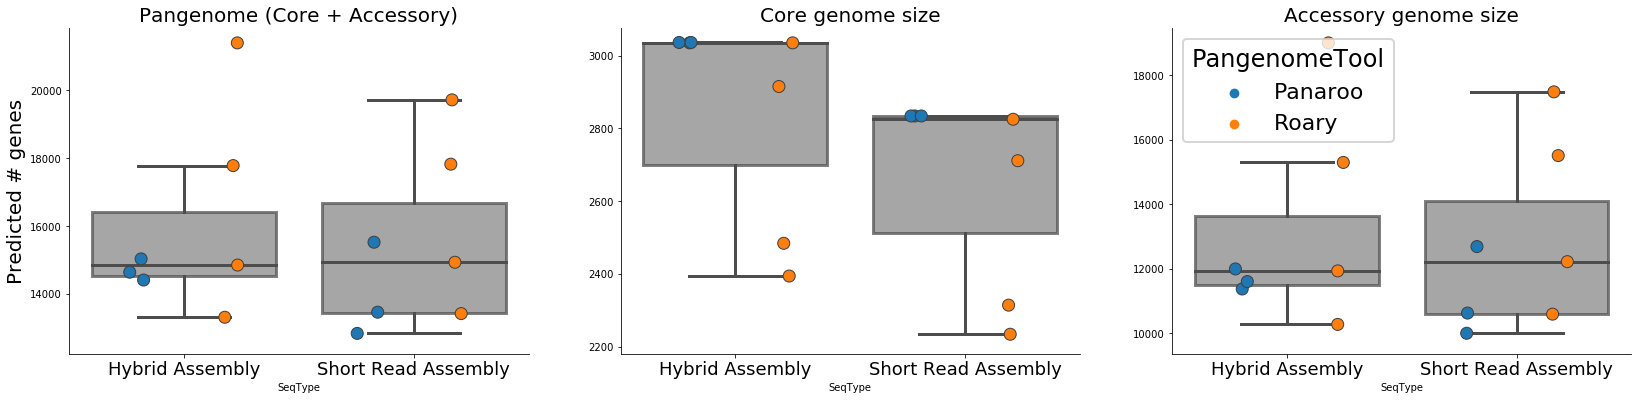

In [51]:
fig, axs = plt.subplots(1, 3, figsize= (28, 6), sharey = False)
sns.set_context("poster")
#sns.set_context("paper", font_scale=1.5)

sns.stripplot(y = "Total genes", x = "SeqType", hue = "PangenomeTool", data = PG_WideSumm_DF, linewidth=1, size = 12, dodge = True, edgecolor='gray', ax= axs[0] )
sns.stripplot(y = "Core genes", x = "SeqType", hue = "PangenomeTool", data = PG_WideSumm_DF, linewidth=1, size = 12, dodge = True, edgecolor='gray', ax= axs[1] )
sns.stripplot(y = "Accessory genes", x = "SeqType", hue = "PangenomeTool", data = PG_WideSumm_DF, linewidth=1, size = 12, dodge = True, edgecolor='gray', ax= axs[2] )

sns.boxplot(y = "Total genes", x = "SeqType", palette = ["grey", "grey"], data = PG_WideSumm_DF, fliersize=0, ax= axs[0] , boxprops=dict(alpha=0.7) )
sns.boxplot(y = "Core genes", x = "SeqType", palette = ["grey", "grey"], data = PG_WideSumm_DF, fliersize=0, ax= axs[1] , boxprops=dict(alpha=0.7) )
sns.boxplot(y = "Accessory genes", x = "SeqType", palette = ["grey", "grey"], data = PG_WideSumm_DF, fliersize=0, ax= axs[2], boxprops=dict(alpha=0.7) )

axs[0].set_title("Pangenome (Core + Accessory)", fontsize= 20)
axs[1].set_title("Core genome size", fontsize= 20)
axs[2].set_title("Accessory genome size", fontsize= 20)

axs[0].set_ylabel("Predicted # genes", fontsize= 20), axs[1].set_ylabel(""), axs[2].set_ylabel("")
# For all 3 "ax" set x tick labels
for i_ax in axs:
    i_ax.set_xticklabels(labels = ["Hybrid Assembly", "Short Read Assembly"], fontsize = 18)

    #i_ax.set_ylim(0, 6250)
    #i_ax.set_xlabel("")

axs[0].get_legend().remove()
axs[1].get_legend().remove()

sns.despine()
#plt.savefig("Plots/4.PG.AllCounts.SRvsLR.WiBakta.Boxplots.png", dpi = 300)
#plt.savefig("Plots/4.PG.AllCounts.SRvsLR.WiBakta.Boxplots.svg")  

#axs[2].legend( bbox_to_anchor=(1.35 , 1))
plt.show()

In [52]:
import matplotlib.patches as mpatches


## Figure 2) Accessory genome predictions - Hybrid vs SR - Bakta + 3 pipelines

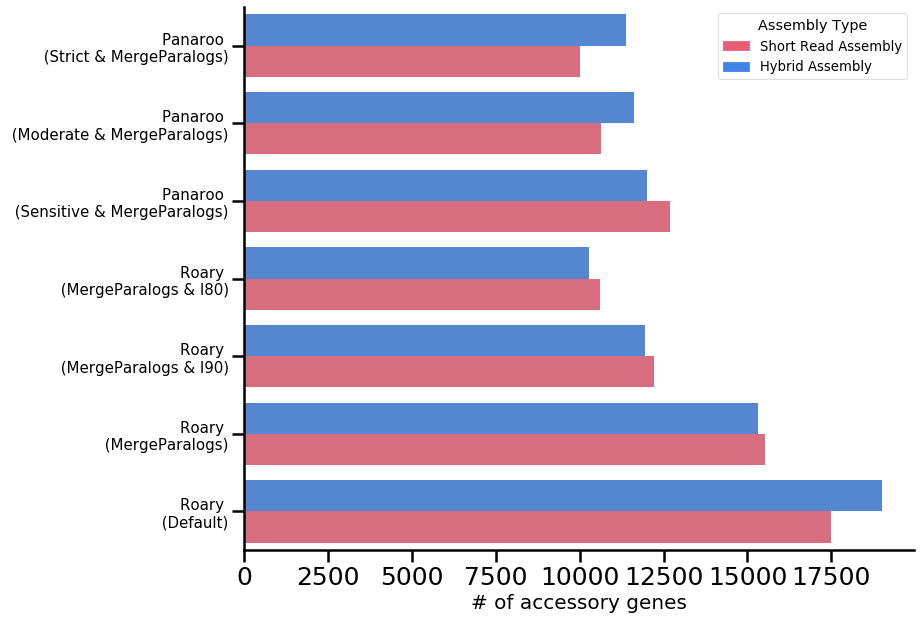

In [53]:
fig, axs = plt.subplots(1, 1, figsize= (12, 10), sharex=True)

#sns.set_context("poster")
sns.set_context("paper", font_scale=1.5)

orderToPlot_X = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs', 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default', ]


sns.barplot(y = "Method", x = "GeneCount", hue = "SeqType", data = PG_Merged_Stats_LRandSR_Acc_DF, order = orderToPlot_X, ax = axs, palette = ["#3F84E5", "#E85D75"] )
#plt.ylim(0, 5000)
# 
#axs.set_ylabel("Pangenome Analysis Pipeline")
axs.set_ylabel("")

axs.set_xlabel("# of accessory genes", fontsize = 20)


Plot_TickLabels = ['Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
                 'Panaroo \n (Sensitive & MergeParalogs)', 'Roary \n (MergeParalogs & I80)', 'Roary \n (MergeParalogs & I90)',
                 'Roary \n (MergeParalogs)',  'Roary \n (Default)', ]

axs.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})

#axs.set_xticklabels(labels = Plot_TickLabels, rotation=45, fontdict = {"fontsize": 12})

SR_patch = mpatches.Patch(color = "#E85D75", label='Short Read Assembly')
Hybrid_patch = mpatches.Patch(color="#3F84E5", label='Hybrid Assembly')

#axs.legend(title = "Assembly Type", labels = ["Hybrid Assembly", "Short Read Assembly"], color = ["#3F84E5", "#E85D75"] )
plt.legend(title = "Assembly Type", handles=[SR_patch, Hybrid_patch])

#axs.set_title("Accessory genome size predictions")
#axs.set_title("Accessory gene counts: Hybrid vs SR assemblies")
sns.despine()
plt.xticks(fontsize=25)
#plt.savefig("Plots/4.PG.AccGeneCounts.SRvsLR.WiBakta.Barplot.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Plots/4.PG.AccGeneCounts.SRvsLR.WiBakta.Barplot.svg", bbox_inches="tight")

#plt.xticks(labels = Plot_TickLabels, rotation=45)
plt.show()

In [54]:
PG_WideSumm_V2_DF.head(2)

,PangenomeTool,SeqType,Method,Total genes,Core genes,Accessory genes,Weight
0,Panaroo,LongRead,Panaroo (Strict & MergeParalogs),14410,3035,11375,10688.5
7,Panaroo,ShortRead,Panaroo (Strict & MergeParalogs),12836,2834,10002,10688.5


In [55]:
PG_Merged_Stats_LRandSR_Pangenome_DF.head(1)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead


In [56]:
PG_Merged_Stats_LRandSR_Acc_DF.head(3)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead
5,Accessory genes,(0% <= strains < 99%),11605,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead
5,Accessory genes,(0% <= strains < 99%),11996,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,All,Panaroo_Sensitive_MergeParalogs_LongRead


## Figure 3) (Supp Figure) Overall Pangenome predictions - Hybrid vs SR - Bakta + 3 pipelines

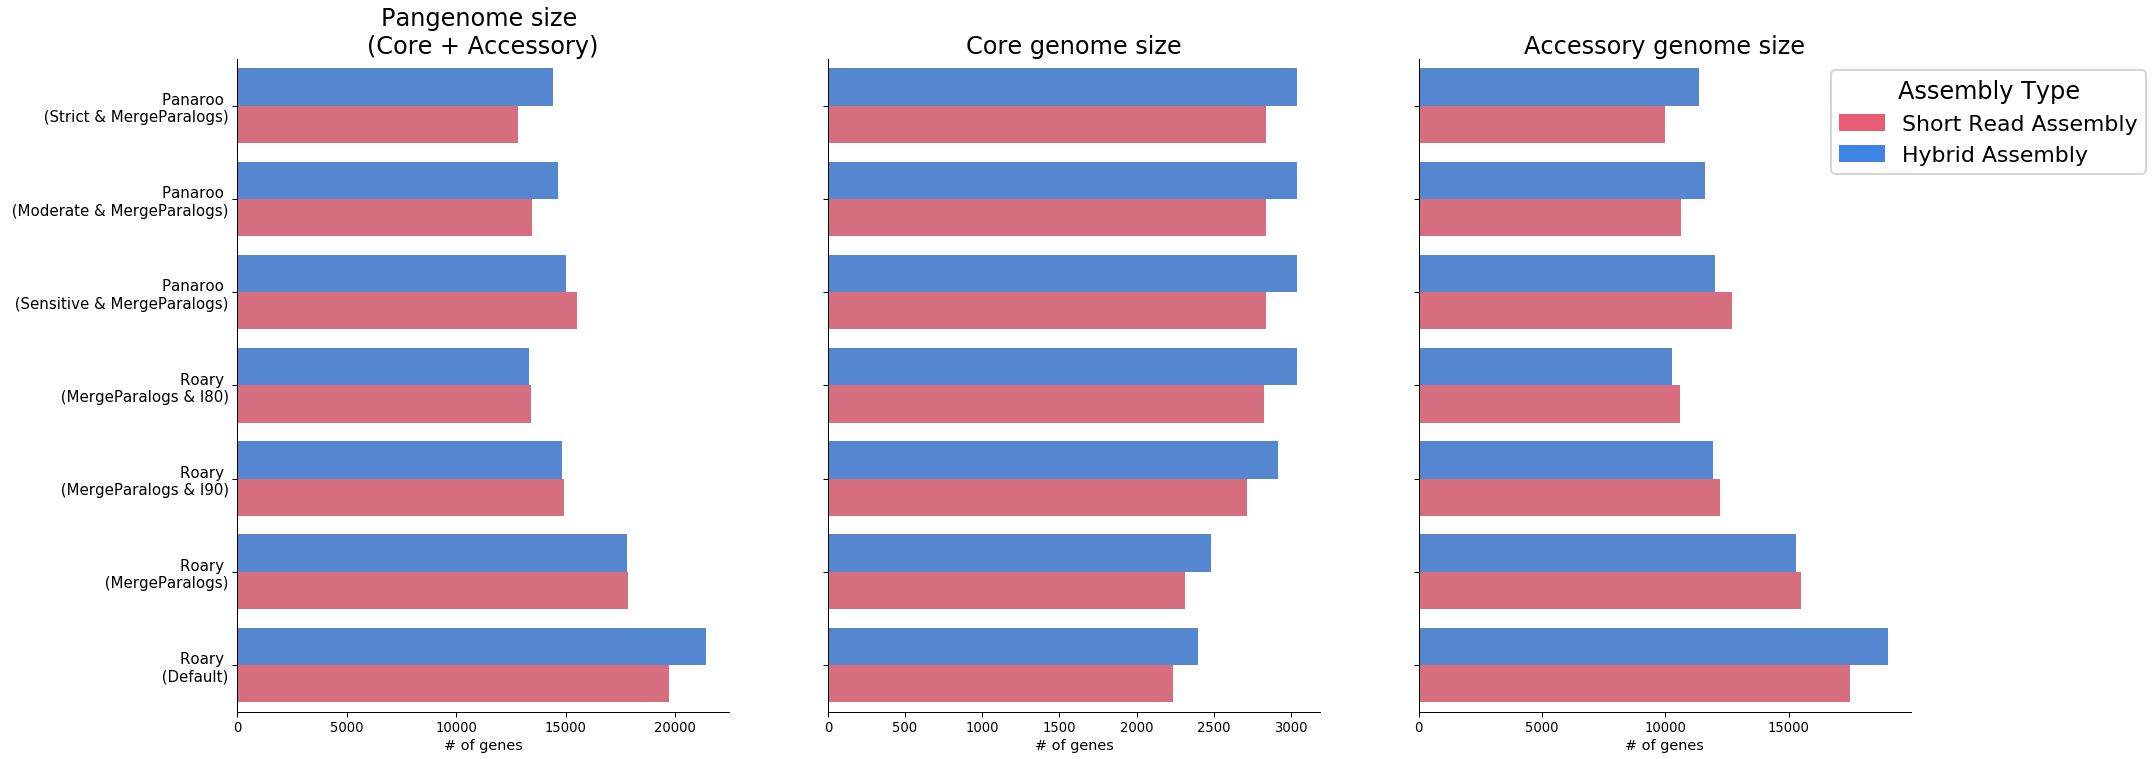

In [57]:
fig, axs = plt.subplots(1, 3, figsize= (30, 12), sharex=False, sharey=True)
sns.set_context("poster")

orderToPlot_X = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs', 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default', ]

sns.barplot(y = "Method", x = "GeneCount", hue = "SeqType", data = PG_Merged_Stats_LRandSR_Pangenome_DF, order = orderToPlot_X, ax = axs[0], palette = ["#3F84E5", "#E85D75"] )
sns.barplot(y = "Method", x = "GeneCount", hue = "SeqType", data = PG_Merged_Stats_LRandSR_Core_DF, order = orderToPlot_X, ax = axs[1], palette = ["#3F84E5", "#E85D75"] )
sns.barplot(y = "Method", x = "GeneCount", hue = "SeqType", data = PG_Merged_Stats_LRandSR_Acc_DF, order = orderToPlot_X, ax = axs[2], palette = ["#3F84E5", "#E85D75"] )

#axs[0].set_ylabel("Pipeline", rotation=0,)
axs[0].set_ylabel("")
axs[1].set_ylabel(""), axs[2].set_ylabel("")

axs[0].set_xlabel("# of genes", rotation=0,)
axs[1].set_xlabel("# of genes", rotation=0,)
axs[2].set_xlabel("# of genes", rotation=0,)


Plot_TickLabels = ['Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
                 'Panaroo \n (Sensitive & MergeParalogs)', 'Roary \n (MergeParalogs & I80)', 'Roary \n (MergeParalogs & I90)',
                 'Roary \n (MergeParalogs)',  'Roary \n (Default)', ]


# For all 3 "ax" set x tick labels
for i_ax in axs:
    i_ax.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})
    #i_ax.set_yticklabels(labels = Plot_TickLabels, rotation=0)

    
SR_patch = mpatches.Patch(color = "#E85D75", label='Short Read Assembly')
Hybrid_patch = mpatches.Patch(color="#3F84E5", label='Hybrid Assembly')

#axs[0].legend(title = "Assembly Type", handles=[SR_patch, Hybrid_patch], bbox_to_anchor=(1.5 , 1.01))
#axs[1].legend(title = "Assembly Type", handles=[SR_patch, Hybrid_patch], bbox_to_anchor=(1.005 , 1))
axs[2].legend(title = "Assembly Type", handles=[SR_patch, Hybrid_patch], bbox_to_anchor=(1.50 , 1))

axs[0].get_legend().remove(), axs[1].get_legend().remove()


axs[0].set_title("Pangenome size \n(Core + Accessory)")
axs[1].set_title("Core genome size")
axs[2].set_title("Accessory genome size")
sns.despine()
#plt.xticks(labels = Plot_TickLabels, rotation=45)
plt.show()

# Try to make side-by-side core vs acc genome comparison plots

In [58]:
PG_Merged_Stats_LRandSR_DF["Category"].unique()

array(['Core genes', 'Total genes', 'Accessory genes'], dtype=object)

In [59]:
PG_Merged_Stats_LRandSR_DF.head(2)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead
4,Total genes,(0% <= strains <= 100%),14410,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead


In [60]:
PG_Merged_Stats_LRandSR_AccAndCore_DF = PG_Merged_Stats_LRandSR_DF.query(" Category != 'Total genes' ")
PG_Merged_Stats_LRandSR_AccAndCore_DF.head(4)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech
0,Core genes,(99% <= strains <= 100%),3035,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead
0,Core genes,(99% <= strains <= 100%),3036,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead
5,Accessory genes,(0% <= strains < 99%),11605,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead


In [61]:
PG_Merged_Stats_LR_AccAndCore_DF = PG_Merged_Stats_LRandSR_AccAndCore_DF.query(" SeqType == 'LongRead' ")
PG_Merged_Stats_LR_AccAndCore_DF.shape

(14, 8)

In [62]:
PG_Merged_Stats_SR_AccAndCore_DF = PG_Merged_Stats_LRandSR_AccAndCore_DF.query(" SeqType == 'ShortRead' ")
PG_Merged_Stats_SR_AccAndCore_DF.shape

(14, 8)

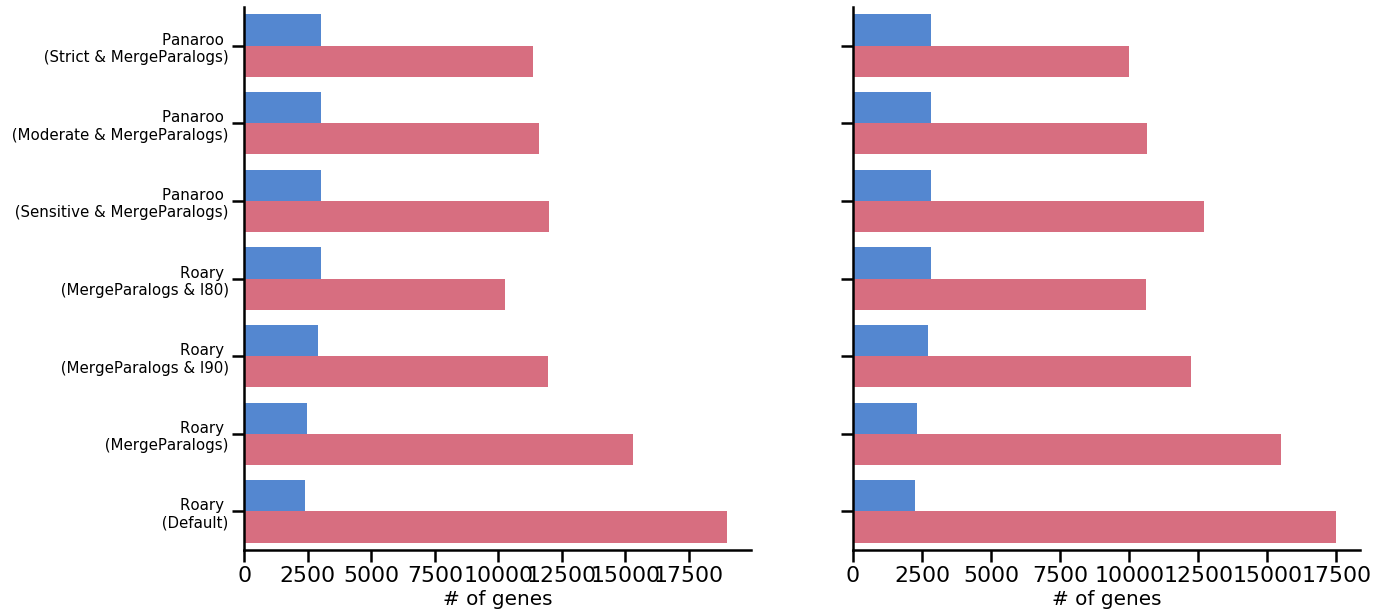

In [63]:
fig, axs = plt.subplots(1, 2, figsize= (20, 10), sharey=True)

#sns.set_context("poster")
sns.set_context("paper", font_scale=1.5)

orderToPlot_X = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs', 'Roary_NoSplitParalogs_I80', 'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default', ]


sns.barplot(y = "Method", x = "GeneCount", hue = "Category", data = PG_Merged_Stats_LR_AccAndCore_DF, order = orderToPlot_X, ax = axs[0], palette = ["#3F84E5", "#E85D75"] )
sns.barplot(y = "Method", x = "GeneCount", hue = "Category", data = PG_Merged_Stats_SR_AccAndCore_DF, order = orderToPlot_X, ax = axs[1], palette = ["#3F84E5", "#E85D75"] )

#axs[0].set_xlim(0, 4000)
#axs[1].set_xlim(0, 4000)

axs[0].set_ylabel("")
axs[1].set_ylabel("")

axs[0].set_xlabel("# of genes", fontsize = 20)
axs[1].set_xlabel("# of genes", fontsize = 20)



Plot_TickLabels = ['Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
                 'Panaroo \n (Sensitive & MergeParalogs)', 'Roary \n (MergeParalogs & I80)', 'Roary \n (MergeParalogs & I90)',
                 'Roary \n (MergeParalogs)',  'Roary \n (Default)', ]

axs[0].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})
axs[1].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 15})

#axs.set_xticklabels(labels = Plot_TickLabels, rotation=45, fontdict = {"fontsize": 12})

#SR_patch = mpatches.Patch(color = "#E85D75", label='Short Read Assembly')
#Hybrid_patch = mpatches.Patch(color="#3F84E5", label='Hybrid Assembly')

#axs[0].legend(title = "Genome Part", labels = ["Core", "Accessory"], color = ["#3F84E5", "#E85D75"] )
#plt.legend(title = "Assembly Type", handles=[SR_patch, Hybrid_patch])

#axs[2].legend(title = "Assembly Type", handles=[SR_patch, Hybrid_patch], bbox_to_anchor=(1.50 , 1))
#axs[0].get_legend().remove(), axs[1].get_legend().remove()
axs[0].get_legend().remove()
axs[1].get_legend().remove()

#axs.set_title("Accessory genome size predictions")
#axs.set_title("Accessory gene counts: Hybrid vs SR assemblies")
sns.despine()
#plt.xticks(fontsize=25)
#plt.savefig("Plots/4.PG.AccGeneCounts.SRvsLR.WiBakta.Barplot.png", dpi = 300)
#plt.savefig("Plots/4.PG.AccGeneCounts.SRvsLR.WiBakta.Barplot.svg")

#plt.xticks(labels = Plot_TickLabels, rotation=45)
plt.show()

In [64]:
PG_Merged_Stats_SeqAndAnnoType_Acc_DF.head(4)

NameError: name 'PG_Merged_Stats_SeqAndAnnoType_Acc_DF' is not defined

ValueError: Could not interpret input 'PangenomeTool'

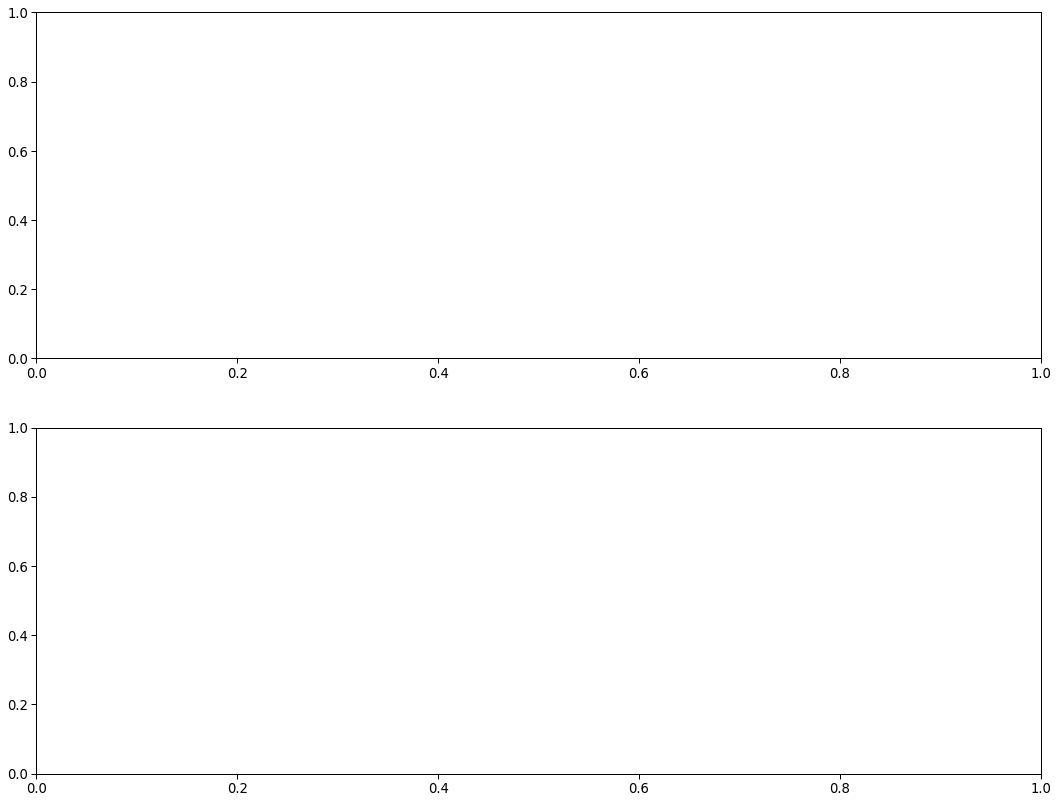

In [65]:
# AnnoAndTech_hue_Color_Dict = { "Bakta-LongRead": "#3F84E5",
#                     "Bakta-ShortRead": "#E85D75",
#                     "PGAP-LongRead": "#ADD8E6",
#                     "PGAP-ShortRead": "#f7bfbe" }

AnnoAndTech_hue_Color_Dict = { "Bakta-LongRead": "#1f77b4",
                    "Bakta-ShortRead": "#ff7f0e",
                    "PGAP-LongRead": "#2ca02c",
                    "PGAP-ShortRead": "#9467bd" }



fig, axs = plt.subplots(2, 1, figsize= (18, 14), sharey = False)
#sns.set_context("poster")
sns.set_context("paper", font_scale=2)


hue_orderToPlot_V2 = ["Bakta-LongRead",  "PGAP-LongRead", "Bakta-ShortRead", "PGAP-ShortRead"]

sns.stripplot(y = "GeneCount", x = "PangenomeTool", hue = "AnnoAndTech", data = PG_Merged_Stats_LRandSR_Acc_DF, linewidth=1, size = 12, palette = AnnoAndTech_hue_Color_Dict, hue_order = hue_orderToPlot_V2, 
              alpha=0.9, dodge = True, edgecolor='gray', ax= axs[0])

sns.boxplot(y = "GeneCount", x = "PangenomeTool", hue = "AnnoAndTech", data = PG_Merged_Stats_LRandSR_Acc_DF, fliersize=0, palette = AnnoAndTech_hue_Color_Dict, hue_order = hue_orderToPlot_V2,
            ax= axs[0], boxprops=dict(alpha=0.7) )


sns.stripplot(y = "GeneCount", x = "PangenomeTool", hue = "AnnoAndTech", data = PG_Merged_Stats_SeqAndAnnoType_Core_DF, linewidth=1, size = 12, palette = AnnoAndTech_hue_Color_Dict, hue_order = hue_orderToPlot_V2, 
              alpha=0.9, dodge = True, edgecolor='gray', ax= axs[1])

sns.boxplot(y = "GeneCount", x = "PangenomeTool", hue = "AnnoAndTech", data = PG_Merged_Stats_SeqAndAnnoType_Core_DF, fliersize=0, palette = AnnoAndTech_hue_Color_Dict, hue_order = hue_orderToPlot_V2,
            ax= axs[1], boxprops=dict(alpha=0.7) )


Bakta_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-LongRead"], label='Bakta & Complete Assemblies (N=151)')
Bakta_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["Bakta-ShortRead"], label='Bakta & Short-Read Assemblies (N=151)')
PGAP_CompAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["PGAP-LongRead"], label='PGAP & Complete Assemblies (N=151)')
PGAP_SRAsm_patch = mpatches.Patch(color = AnnoAndTech_hue_Color_Dict["PGAP-ShortRead"], label='PGAP & Short-Read Assemblies (N=151)')

axs[0].legend(title = "Annotation/Assembly Combo", handles=[Bakta_CompAsm_patch, PGAP_CompAsm_patch, Bakta_SRAsm_patch, PGAP_SRAsm_patch], bbox_to_anchor=(1.65, 1))
axs[1].get_legend().remove()

axs[0].set_xlabel("")
axs[1].set_xlabel("")

axs[0].set_ylabel("# estimated accessory genes", fontsize=20)
axs[1].set_ylabel("# estimated core genes", fontsize=20)

axs[0].set_xticklabels(labels = ["Panaroo", "Roary", "PPanGGolin"], fontsize = 24)
axs[1].set_xticklabels(labels = ["Panaroo", "Roary", "PPanGGolin"], fontsize = 24)

axs[0].set_yticklabels(axs[0].get_yticks().astype(int), fontsize=20)
axs[1].set_yticklabels(axs[1].get_yticks().astype(int), fontsize=20)

sns.despine()

#plt.savefig("Results3_Plots/3.PG.Counts.OverallCounts.Boxplots.png", dpi = 300, bbox_inches="tight")
#plt.savefig("Results3_Plots/3.PG.Counts.OverallCounts.Boxplots.svg", bbox_inches="tight")

plt.show()

## Pivot table to get summary per Method and Seqtype

In [113]:
PG_Merged_Stats_LR_Acc_DF.head(4)

,Category,Range,GeneCount,Annotation,Method,SeqType,DataSet,MethodAndTech
5,Accessory genes,(0% <= strains < 99%),11375,Bakta,Panaroo_Strict_MergeParalogs,LongRead,All,Panaroo_Strict_MergeParalogs_LongRead
5,Accessory genes,(0% <= strains < 99%),11605,Bakta,Panaroo_Moderate_MergeParalogs,LongRead,All,Panaroo_Moderate_MergeParalogs_LongRead
5,Accessory genes,(0% <= strains < 99%),11996,Bakta,Panaroo_Sensitive_MergeParalogs,LongRead,All,Panaroo_Sensitive_MergeParalogs_LongRead
5,Accessory genes,(0% <= strains < 99%),10277,Bakta,Roary_NoSplitParalogs_I80,LongRead,All,Roary_NoSplitParalogs_I80_LongRead


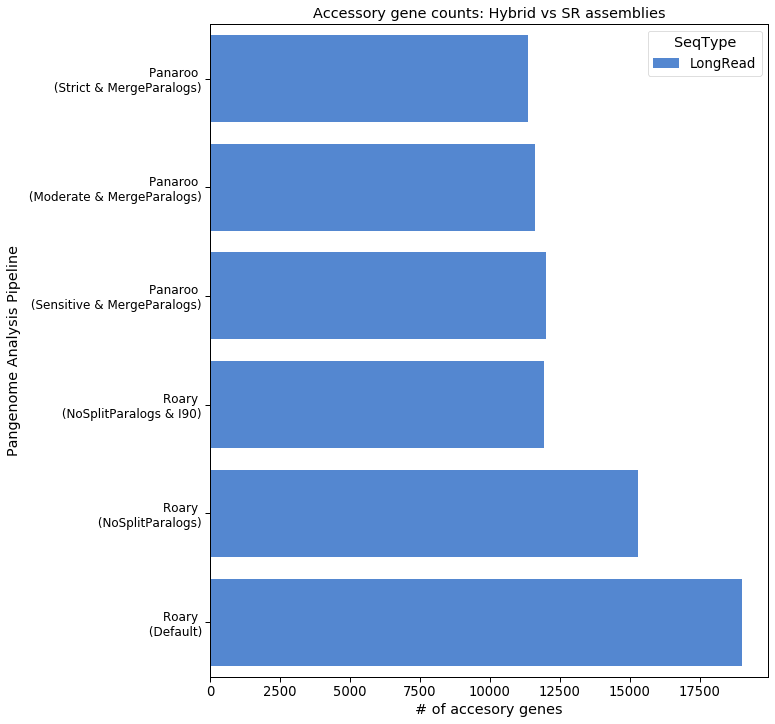

In [115]:
fig, axs = plt.subplots(1, 1, figsize= (10, 12), sharex=True)


orderToPlot_X = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs',  'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default' ]


sns.barplot(y = "Method", x = "GeneCount", hue = "SeqType", data = PG_Merged_Stats_LR_Acc_DF, order = orderToPlot_X, ax = axs, palette = ["#3F84E5", "#E85D75"] )
#plt.ylim(0, 5000)
# 
axs.set_ylabel("Pangenome Analysis Pipeline")
axs.set_xlabel("# of accesory genes")


Plot_TickLabels = ['Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
                 'Panaroo \n (Sensitive & MergeParalogs)', 'Roary \n (NoSplitParalogs & I90)',
                 'Roary \n (NoSplitParalogs)',  'Roary \n (Default)']

axs.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 12})

#axs.set_xticklabels(labels = Plot_TickLabels, rotation=45, fontdict = {"fontsize": 12})

axs.set_title("Accessory gene counts: Hybrid vs SR assemblies")

#plt.xticks(labels = Plot_TickLabels, rotation=45)
plt.show()

In [ ]:
fig, axs = plt.subplots(1, 1, figsize= (10, 12), sharex=True)


orderToPlot_X = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs',  'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default' ]


sns.barplot(y = "Method", x = "GeneCount", hue = "SeqType", data = PG_Merged_Stats_SR_Acc_DF, order = orderToPlot_X, ax = axs, palette = ["#3F84E5", "#E85D75"] )
#plt.ylim(0, 5000)
# 
axs.set_ylabel("Pangenome Analysis Pipeline")
axs.set_xlabel("# of accesory genes")


Plot_TickLabels = ['Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
                 'Panaroo \n (Sensitive & MergeParalogs)', 'Roary \n (NoSplitParalogs & I90)',
                 'Roary \n (NoSplitParalogs)',  'Roary \n (Default)']

axs.set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 12})

#axs.set_xticklabels(labels = Plot_TickLabels, rotation=45, fontdict = {"fontsize": 12})

axs.set_title("Accessory gene counts: Hybrid vs SR assemblies")

#plt.xticks(labels = Plot_TickLabels, rotation=45)
plt.show()

In [55]:
PG_Summ_LR_T2_DF = pd.pivot(PG_Merged_Stats_DF,
         index = ["AnnoAndMethod"],
         columns = ["Category"],
         values = ["GeneCount"] )

PG_Summ_LR_T2_DF.columns = PG_Summ_LR_T2_DF.columns.droplevel(0)
PG_Summ_LR_T2_DF.columns.name = None
PG_Summ_LR_T2_DF = PG_Summ_LR_T2_DF.reset_index()


PG_Summ_LR_T2_DF["Anno"] = PG_Summ_LR_T2_DF["AnnoAndMethod"].str.split("_").str[0:1].str[0]
PG_Summ_LR_T2_DF["PangenomeTool"] = PG_Summ_LR_T2_DF["AnnoAndMethod"].str.split("_").str[1:2].str[0]
PG_Summ_LR_T2_DF['SeqType'] = "LongRead"
PG_Summ_LR_T2_DF["Method"] = PG_Summ_LR_T2_DF["AnnoAndMethod"].str.replace("Bakta_", "").str.replace("PGAP_", "")

# Do some reformatting 
NewColOrder = ['SeqType', 'PangenomeTool', 'Method','Anno',  'Total genes',  'Core genes', 'Accessory genes',  ]
#NewColOrder = ['SeqType', 'Anno', 'Method', 'Total genes',  'Core genes', 'Accessory genes',  ]

PG_Summ_LR_T2_DF = PG_Summ_LR_T2_DF[NewColOrder]


PG_Summ_LR_T2_DF = PG_Summ_LR_T2_DF.sort_values(["Method", "Anno"]).reset_index(drop=True)


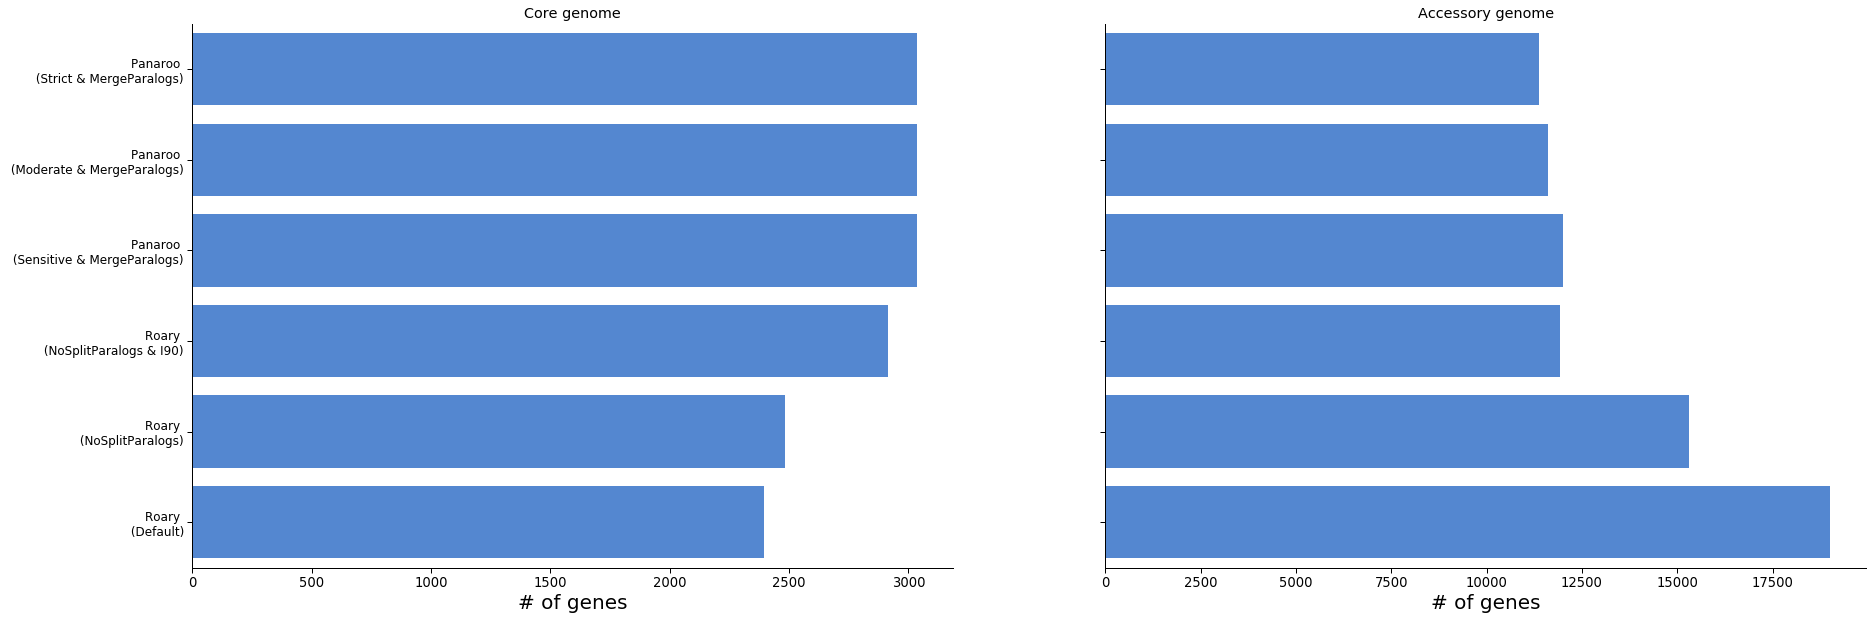

In [69]:
fig, axs = plt.subplots(1, 2, figsize= (30, 10), sharex=False, sharey=True)

sns.set_context("paper", font_scale=1.5)


orderToPlot_X = ['Panaroo_Strict_MergeParalogs', 'Panaroo_Moderate_MergeParalogs',
                 'Panaroo_Sensitive_MergeParalogs',  'Roary_NoSplitParalogs_I90',
                 'Roary_NoSplitParalogs',  'Roary_Default',]


#sns.barplot(y = "Method", x = "GeneCount", hue = "SeqType", data = PG_Merged_Stats_LR_Pangenome_DF, order = orderToPlot_X, ax = axs[0], palette = ["#3F84E5", "#E85D75"] )
sns.barplot(y = "Method", x = "GeneCount", hue = "SeqType", data = PG_Merged_Stats_LR_Core_DF, order = orderToPlot_X, ax = axs[0], palette = ["#3F84E5", "#E85D75"] )
sns.barplot(y = "Method", x = "GeneCount", hue = "SeqType", data = PG_Merged_Stats_LR_Acc_DF, order = orderToPlot_X, ax = axs[1], palette = ["#3F84E5", "#E85D75"] )

axs[0].set_ylabel("Pipeline", rotation=0,)
axs[1].set_ylabel("")

axs[0].set_ylabel("")
axs[1].set_ylabel("")
#axs[0].set_xlabel("# of genes", rotation=0,)
#axs[1].set_xlabel("# of genes", rotation=0,)
axs[0].set_xlabel("# of genes", fontsize = 20)
axs[1].set_xlabel("# of genes", fontsize = 20)

Plot_TickLabels = ['Panaroo \n (Strict & MergeParalogs)', 'Panaroo \n (Moderate & MergeParalogs)',
                 'Panaroo \n (Sensitive & MergeParalogs)', 'Roary \n (NoSplitParalogs & I90)',
                 'Roary \n (NoSplitParalogs)',  'Roary \n (Default)',]


#axs[0].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 12})
axs[0].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 12})
axs[1].set_yticklabels(labels = Plot_TickLabels, rotation=0, fontdict = {"fontsize": 12})

axs[0].get_legend().remove()
axs[1].get_legend().remove()

axs[0].set_title("Core genome")
axs[1].set_title("Accessory genome")
sns.despine()
#plt.xticks(labels = Plot_TickLabels, rotation=45)
plt.show()